Recall the finite difference approximations of a derivative:

$$g_1(\theta)=f^\prime(\theta)\approx\frac{f(\theta+\delta)-f(\theta)}{\delta}$$

and 

$$g_2(\theta)=f^\prime(\theta)\approx\frac{f(\theta+\delta)-f(\theta-\delta)}{2\delta}$$

For holomorphic functions, we can also approximate the derivative 

$$g_3(\theta)=f^\prime(\theta)\approx\frac{Imag[f(\theta+i\delta)]}{\delta}$$

* Numerical approximations to derivatives have two sources of error. 
* **Truncation error**: Step-size $\neq$ zero to approximate the limit definition of the derivative
  * smaller the step-size, the smaller the truncation error.
  * The truncation error is $\operatorname{O}(\delta)$ for $g_1$ and $\operatorname{O}(\delta^2)$ for $g_2$ and $g_3$.
* **Rounding error**: Introduced by smaller and smaller step-size due to the subtraction terms in the approximations  
  * The round-off error is $\operatorname{O}(\delta^{-1})$
  * Note that $g_3(\theta)$ does not have a subtraction term, and, in fact, we can choose an arbitrarily small step-size for this function, as you can see in the plots below.


How rounding-error occurs

$$\frac{(1234.1234 - 1234.1236)}{.00001}=\frac{.2\times10^{-3}}{.1\times10^-4}=(\frac{.2}{.1})(10^{-3}/10^{-4})=20$$

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
print(((np.float32(1234.1234) - np.float32(1234.1236))/ np.float32(1e-5)))

-24.4141


We will discuss truncation error in more detail when we deal with Taylor Series and simulation techniques.

In [10]:
class Derivative(object):
    """
    Object to evaluate a derivative using forward difference.

    Parameters
    ----------
    func : function
        Function for which you want to evaluate the derivative.

    Returns
    -------
    der : Derivative
        A callable object that returns the derivative of `func`

    Notes
    -----
    Based on univariate versions of statsmodels.tools.numdiff
    """
    
    def __init__(self, func):
        self.func = func
    
    def _approx_fprime(self, x, h=1e-8, args=(), **kwargs):
        f = self.func
        f_x = f(*((x,)+args), **kwargs)
        return (f(*((x+h,)+args), **kwargs) - f_x)/h
    
    def _approx_fprime_centered(self, x, h=1e-8, args=(), 
                                      **kwargs):
        f = self.func
        return (f(*((x+h,)+args), **kwargs) -
                f(*((x-h,)+args), **kwargs))/(2*h)
    
    def _approx_fprime_cs(self, x, h=1e-8, args=(), **kwargs):
        f = self.func
        ih = h*1j
        return f(x+ih, *args, **kwargs).imag / h

    
    def __call__(self, x, h=1e-8, method="fwd"):
        """
        Return the derivative of self.func using forward difference.
        
        Parameters
        ----------
        x : scalar
            The number at which to differentiate.
        h : float, optional
            The step-size for the forward difference.
        method : str {"fwd", "centered", "complex"}
            The method of differentiation to use
    
        Returns
        -------
        f'(x) : scalar
            The derivative of func evaluated at x
        """
        if method == "fwd":
            return self._approx_fprime(x, h)
        
        elif method == "centered":
            return self._approx_fprime_centered(x, h)
        
        elif method == "complex":
            return self._approx_fprime_cs(x, h)
        
        else:
            raise ValueError("Method not understood")

`__call__` is a special method name for Python classes. You can learn more about the use of special methods [here](http://docs.python.org/2/reference/datamodel.html#special-method-names).

In [11]:
def func(theta):
    return 4*np.log(theta) - theta

EPS = np.finfo(float).eps # machine epsilon

deltas = 10**np.linspace(-20, 0, 1e3)

derivative = Derivative(func)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


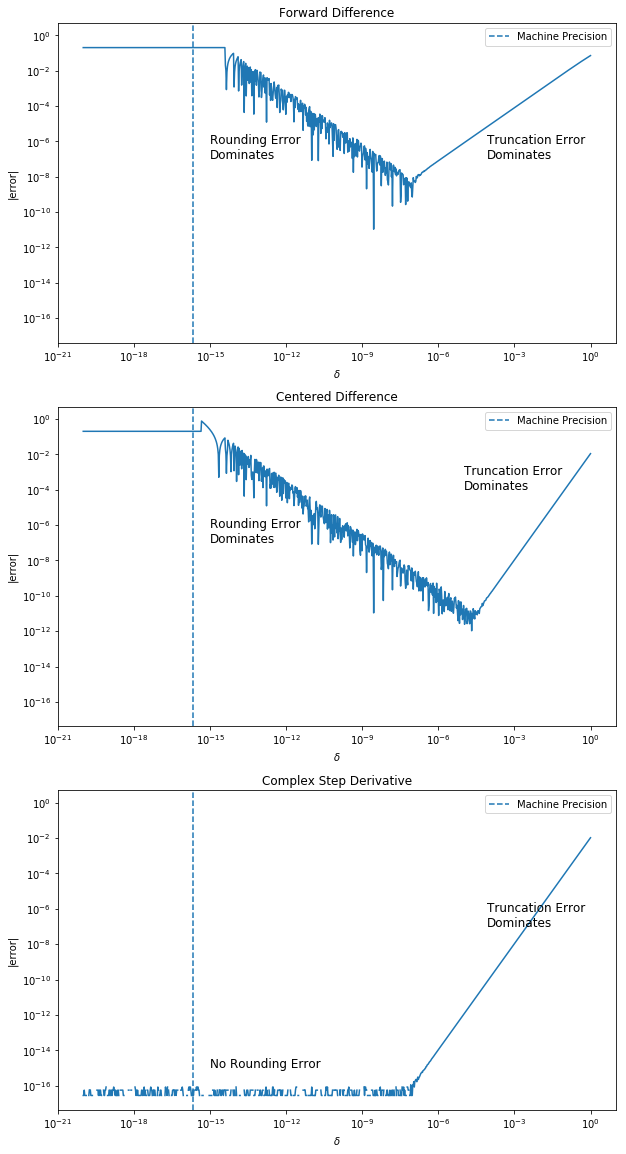

In [12]:
approx_fprime = [derivative(np.array([5]), eps) 
                 for eps in deltas]
errors = np.abs(-1/5. - np.array(approx_fprime))

approx_fprime_cent = [derivative(np.array([5]), eps, "centered")
                      for eps in deltas]
errors_cent = np.abs(-1/5. - np.array(approx_fprime_cent))

approx_fprime_cs = [derivative(np.array([5]), eps, "complex") 
                    for eps in deltas]
errors_cs = np.abs(-1/5. - np.array(approx_fprime_cs)).squeeze()
# some of the errors are below machine precision so we get -inf
# this is underflow

fig = plt.figure(figsize=(10,20))
ax1 = fig.add_subplot(311, xlabel='$\delta$', 
            ylabel='|error|', xscale='log', yscale='log');
ax1.axvline(EPS, linestyle='--', label='Machine Precision');
ax1.legend();
ax1.plot(deltas, errors);
ax1.set_title("Forward Difference")
ax1.annotate("Truncation Error\nDominates", 
              (.8e-4, 1e-7), size="large")
ax1.annotate("Rounding Error\nDominates", 
              (1e-15, 1e-7), size="large")


ax2 = fig.add_subplot(312, xlabel='$\delta$', 
            ylabel='|error|', sharex=ax1, sharey=ax1);
ax2.axvline(EPS, linestyle='--', label='Machine Precision');
ax2.legend();
ax2.plot(deltas, errors_cent);
ax2.set_title("Centered Difference")
ax2.annotate("Truncation Error\nDominates", 
              (1e-5, 1e-4), size="large")
ax2.annotate("Rounding Error\nDominates", 
              (1e-15, 1e-7), size="large")

ax3 = fig.add_subplot(313, xlabel='$\delta$', 
            ylabel='|error|', sharex=ax1, sharey=ax1);
ax3.axvline(EPS, linestyle='--', label='Machine Precision');
ax3.legend();
ax3.plot(deltas, errors_cs);
ax3.set_title("Complex Step Derivative");
ax3.annotate("Truncation Error\nDominates", 
              (.8e-4, 1e-7), size="large")
ax3.annotate("No Rounding Error", 
              (1e-15, 1e-15), size="large");
plt.show()

**References**

Ridout, M.S. (2009) "Statistical Applications of the Complex-Step Method of Numerical Differentiation." *The American Statistician,* 63(1), 66-74.